In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## 파라미터 초기화

In [2]:
confThreshold = 0.5 # Confidence threshold
nmsThreshold = 0.4 # Non-maximum suppression threshold
inpWidth = 416 # 608 # 입력 이미지 너비 
inpHeight = 416 # 608 # 입력 이미지 높이

## 네트워크(모델) 생성

In [3]:
def build_net():
    # 네트워크(모델) 설정
    modelConfiguration = "weights/model-yolov3.cfg"
    modelWeights = "weights/model.weights"
    net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

    return net

## output layers 이름 반환

In [4]:
def getOutputsNames(net):
    layersNames = net.getLayerNames()
    
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]

## 바운딩 박스 전처리

In [5]:
def postprocess(frame, outs):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]

    classIds = []
    confidences = []
    boxes = []
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            # if detection[4] > 0.001:
            scores = detection[5:]
            classId = np.argmax(scores)
            # if scores[classId] > confThreshold:
            confidence = scores[classId]
            
            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    if not boxes:
        return None
    
    result = []
    # 같은 물체에 대해서 박스가 많은 것을 제거 -> Non maximum suppresion
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    for i in indices:
        x, y, w, h = boxes[i[0]]
        result.append((x, y, w, h))
    
    return result

## 번호판 탐지

In [6]:
def license_plate_detection(img):
    # 네트워크 빌드
    net = build_net()

    # 입력 이미지로 부터 4D Blob(4D Binary Large OBjects) 생성
    blob = cv2.dnn.blobFromImage(img, 1/255, (inpWidth, inpHeight), [0, 0, 0], 1, crop=False)

    # 네트워크를 통해 번호판을 탐지
    net.setInput(blob)
    outs = net.forward(getOutputsNames(net))

    # 확실하게 탐지된 바운딩 박스 반환, 탐지되지 않았을 시 None 반환 
    return postprocess(img, outs) 

## 입력 이미지 로드 및 결과 이미지 경로 설정

In [7]:
img_dir = "img/"
img_name = "1.png"
result_dir = "output/"
img = cv2.imread(img_dir+img_name)
license_plate_output = result_dir+img_name[:-4]+'_license_plate.png'
box_output = result_dir+img_name[:-4]+'_box.png'

## 확실하게 탐지된 번호판이 있다면 번호판 이미지와 
## 바운딩 박스를 포함한 전체 이미지를 저장

3 Detect


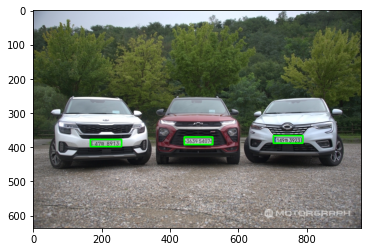

In [8]:
# 확실하게 탐지된 번호판이 있다면 번호판 이미지와 바운딩 박스를 포함한 전체 이미지를 저장
result = license_plate_detection(img)

if not result:
    print("Not detect")
else:
    print(f"{len(result)} Detect")
    box_img = img.copy()
    for i, box in enumerate(result):
        x, y, w, h = box
        # 번호판 이미지 저장
        license_plate_img = img[y:y+h, x:x+w, ::]
        cv2.imwrite(f"{license_plate_output[:-4]}_{i}_{license_plate_output[-4:]}", license_plate_img.astype(np.uint8))

        # 바운딩 박스를 포함한 전체 이미지 저장
        cv2.rectangle(box_img, (x, y), (x+w, y+h), (0, 255, 0), 3)
    cv2.imwrite(box_output, box_img.astype(np.uint8))
    plt.imshow(box_img[::, ::, ::-1])